# Data Exploration

In this notebook, we will explore the data downloaded for the project, understand it and visualize it.
There are multiple things we want to see really:
- First a couple of random samples to get a feeling for the data (e.g. visualise the bounding boxes)
- The distribution of the classes, make sure we're not prioritizing one class over the other
- The size of the tumors, we want to see if our dataset contains a good variety of sizes

### Random Samples

First let's take a look at a couple of random samples to get a feeling for the data.

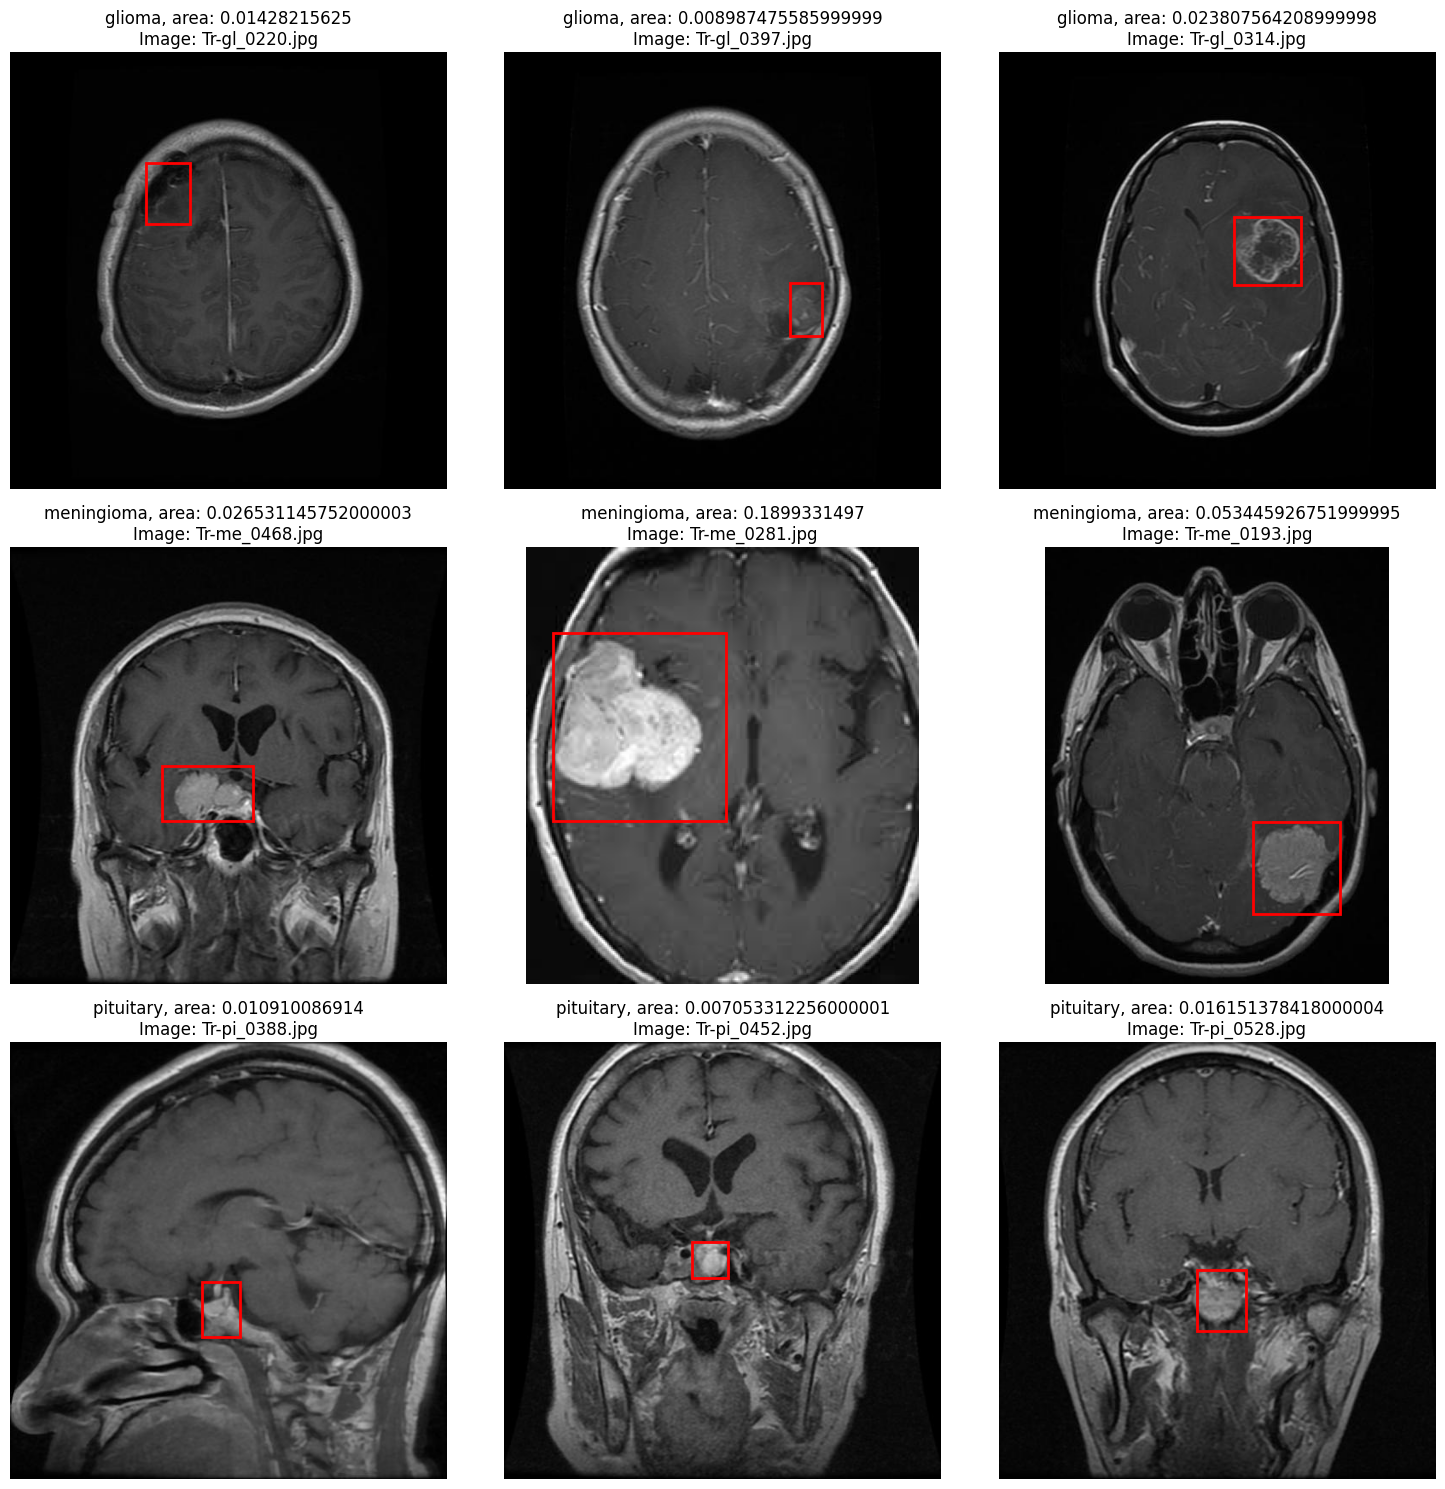

In [ ]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def visualize_random_samples(base_path=".", samples_per_class=3):
    # Classes to visualize (excluding notumor since it has no bounding boxes)
    classes = ['glioma', 'meningioma', 'pituitary']
    
    # Calculate subplot dimensions
    n_rows = len(classes)
    n_cols = samples_per_class
    plt.figure(figsize=(15, 5 * len(classes)))
    
    for class_idx, class_name in enumerate(classes):
        # Get all image files for this class
        img_files = glob.glob(os.path.join(base_path, class_name, "*.jpg"))
        
        # Randomly select images
        selected_imgs = random.sample(img_files, min(samples_per_class, len(img_files)))
        
        for img_idx, img_path in enumerate(selected_imgs):
            # Load image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            height, width = img.shape[:2]
            
            # Load corresponding annotation
            txt_path = img_path.replace('.jpg', '.txt')
            
            # Create subplot
            plt_idx = class_idx * n_cols + img_idx + 1
            plt.subplot(n_rows, n_cols, plt_idx)
            
            # Display image
            plt.imshow(img)
            
            # Read and draw bounding box
            try:
                with open(txt_path, 'r') as f:
                    line = f.readline().strip().split()
                    if len(line) >= 5:
                        _, x_center, y_center, box_width, box_height = map(float, line)
                        area = box_width * box_height
                        
                        # Convert normalized coordinates to pixel coordinates
                        x_center = int(x_center * width)
                        y_center = int(y_center * height)
                        box_width = int(box_width * width)
                        box_height = int(box_height * height)
                        
                        # Calculate box corners
                        x1 = int(x_center - box_width/2)
                        y1 = int(y_center - box_height/2)
                        
                        # Create rectangle patch
                        plt.gca().add_patch(plt.Rectangle(
                            (x1, y1),
                            box_width,
                            box_height,
                            fill=False,
                            color='red',
                            linewidth=2
                        ))
            except Exception as e:
                print(f"Error reading annotation for {txt_path}: {e}")
            
            plt.title(f"{class_name}, area: {area}\nImage: {os.path.basename(img_path)}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

raw_dataset_path = Path("./datasets/raw/raw/")
visualize_random_samples(raw_dataset_path, samples_per_class=3)

### Tumor Class, Size Distribution

Next, we will look at the distribution of the classes in the dataset. We want to make sure that we have a good distribution of the classes, so that the model doesn't overfit to one class. We will also look at the size of the tumors, to see if we have a good variety of sizes in the dataset.

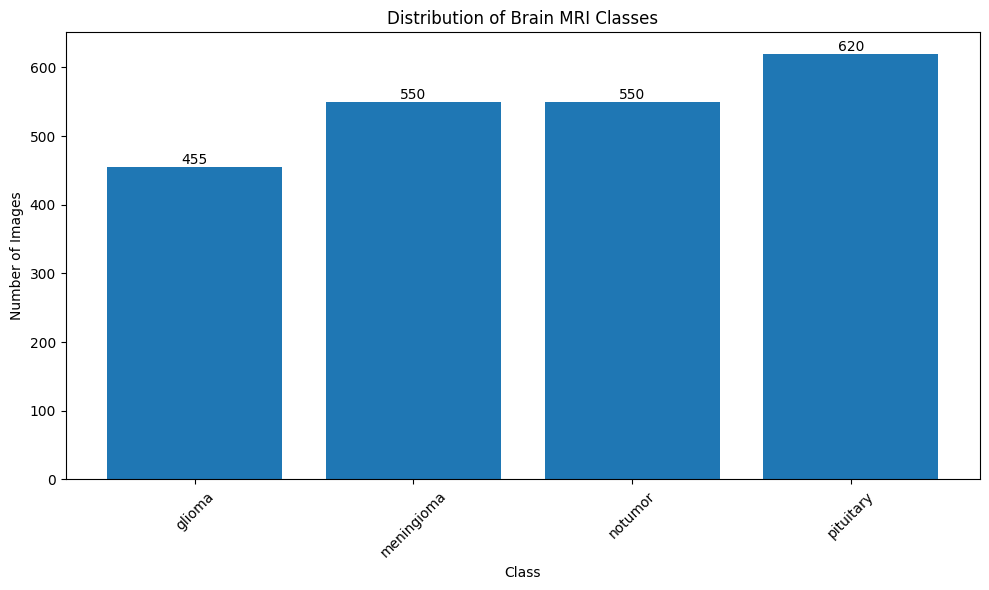

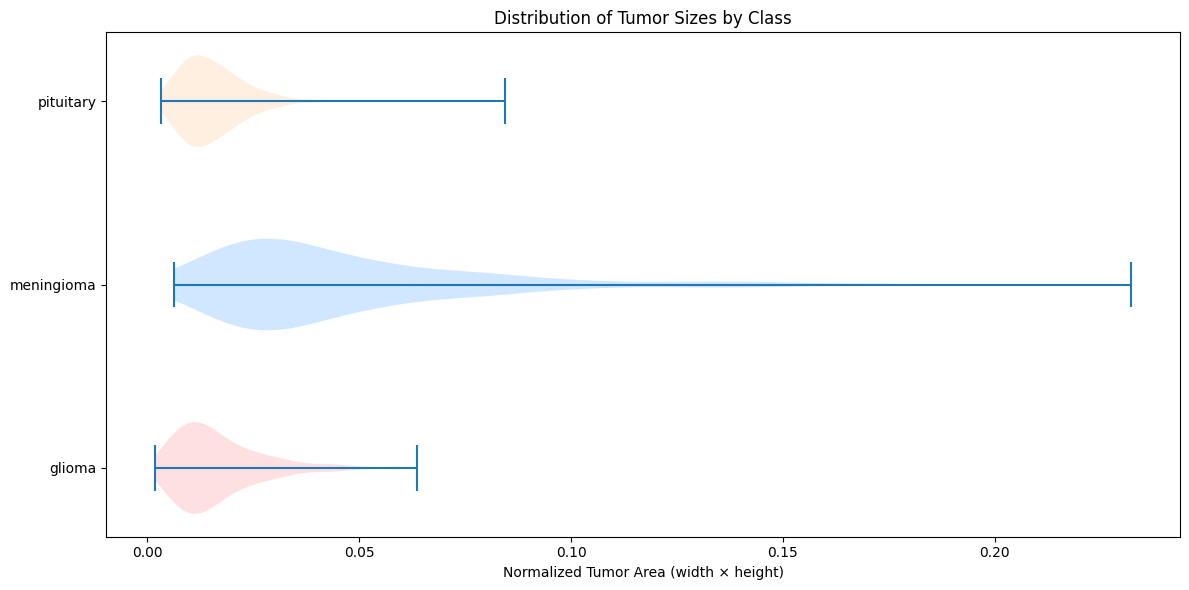

<Figure size 1200x600 with 0 Axes>

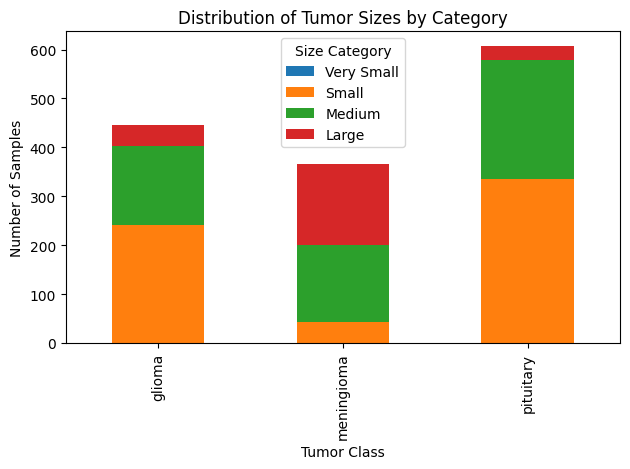


Summary Statistics:

GLIOMA:
Mean area: 0.0169
Median area: 0.0143
Std dev: 0.0109
Min area: 0.0019
Max area: 0.0638

MENINGIOMA:
Mean area: 0.0473
Median area: 0.0366
Std dev: 0.0342
Min area: 0.0064
Max area: 0.2321

PITUITARY:
Mean area: 0.0166
Median area: 0.0144
Std dev: 0.0105
Min area: 0.0033
Max area: 0.0844


In [17]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def analyze_tumor_dataset(base_path="."):
    # Initialize data structures
    class_counts = {}
    tumor_sizes = {
        'glioma': [],
        'meningioma': [],
        'pituitary': []
    }
    
    # Collect data
    classes_to_analyze = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for tumor_class in classes_to_analyze:
        txt_files = glob.glob(os.path.join(base_path, tumor_class, "*.txt"))
        jpg_files = glob.glob(os.path.join(base_path, tumor_class, "*.jpg"))
        class_counts[tumor_class] = len(jpg_files)  # Count images instead of txt files
        
        # Read tumor sizes from annotation files (skip for notumor)
        if tumor_class != 'notumor':
            for txt_file in txt_files:
                try:
                    with open(txt_file, 'r') as f:
                        line = f.readline().strip().split()
                        if len(line) >= 5:  # Ensure we have all coordinates
                            _, _, _, width, height = map(float, line)
                            area = width * height  # Normalized area
                            tumor_sizes[tumor_class].append(area)
                except Exception as e:
                    print(f"Error reading {txt_file}: {e}")
    
    # 1. Class Distribution Analysis
    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Distribution of Brain MRI Classes')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    for i, v in enumerate(class_counts.values()):
        plt.text(i, v, str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    
    # 2. Tumor Size Distribution Analysis
    plt.figure(figsize=(12, 6))
    
    # Create violin plots for size distribution (excluding notumor)
    data_to_plot = list(tumor_sizes.values())
    labels = list(tumor_sizes.keys())
    
    violin_parts = plt.violinplot(data_to_plot, points=100, vert=False)
    plt.yticks(range(1, len(labels) + 1), labels)
    plt.xlabel('Normalized Tumor Area (width × height)')
    plt.title('Distribution of Tumor Sizes by Class')
    
    # Customize violin plot colors
    colors = ['#FF9999', '#66B2FF', '#FFCC99']
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i % len(colors)])
    
    plt.tight_layout()
    plt.show()
    
    # 3. Size Categories Analysis
    def categorize_size(area):
        if area < 0.015:
            return 'Small'
        elif area < 0.03:
            return 'Medium'
        elif area < 0.05:
            return 'Large'
        else:
            return 'Very Large'
    
    # Create size categories DataFrame
    size_data = []
    for class_name, areas in tumor_sizes.items():
        categories = [categorize_size(area) for area in areas]
        category_counts = pd.Series(categories).value_counts()
        size_data.append({
            'class': class_name,
            'Very Small': category_counts.get('Very Small', 0),
            'Small': category_counts.get('Small', 0),
            'Medium': category_counts.get('Medium', 0),
            'Large': category_counts.get('Large', 0)
        })
    
    size_df = pd.DataFrame(size_data)
    size_df.set_index('class', inplace=True)
    
    # Plot size categories
    plt.figure(figsize=(12, 6))
    size_df.plot(kind='bar', stacked=True)
    plt.title('Distribution of Tumor Sizes by Category')
    plt.xlabel('Tumor Class')
    plt.ylabel('Number of Samples')
    plt.legend(title='Size Category')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    for class_name, areas in tumor_sizes.items():
        if areas:
            print(f"\n{class_name.upper()}:")
            print(f"Mean area: {np.mean(areas):.4f}")
            print(f"Median area: {np.median(areas):.4f}")
            print(f"Std dev: {np.std(areas):.4f}")
            print(f"Min area: {np.min(areas):.4f}")
            print(f"Max area: {np.max(areas):.4f}")

analyze_tumor_dataset("./datasets/raw/raw/")

### Raw Data Notes

It looks like we have a balanced dataset when it comes to classes of tumors. But when looking at the sizes, we're missing very small tumors. The dataset mainly contains medium to large tumors. This is something to keep in mind when evaluating the model later on. It also looks like `meningioma` tumors can grow the largest in our dataset. I'm pretty sure this is because of the axial slices (i.e. the ones taken from the top of the skull, where meningioma tumors are most likely to grow), where the meniongioma tumors might cover a larger area, but might not be very deep.

## Augmented Data Analysis

In this section, we will analyze the augmented data. We will look at the distribution of the classes and the sizes of the tumors in the augmented dataset. It should have remained unchanged since we're augmenting all classes equally. We can also look at average similarity scores between the images, to make sure they are different enough and we are not just adding noise to the dataset, and thus at risk of overfitting the model at training time.

### Visualizing the Augmented Data Samples

But as before, let's first take a look at a couple of random samples to get a feeling for the data.

In [18]:
import shutil

def create_augmented_folder(base_path=".", output_path="."):
        """
        Create a new augmented folder for analysis.
        This is just helpful to be able to use the various original analysis functions.
        """
        source_folders = ['images', 'labels']
        class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
        for tumor_class in class_names:
            os.makedirs(os.path.join(output_path, tumor_class), exist_ok=True)
        for folder in source_folders:
            for file in os.listdir(os.path.join(base_path, folder)):
                if "gl" in file:
                     shutil.copy2(os.path.join(base_path, folder, file), os.path.join(output_path, 'glioma', file))
                elif "me" in file:
                    shutil.copy2(os.path.join(base_path, folder, file), os.path.join(output_path, 'meningioma', file))
                elif "no" in file:
                    shutil.copy2(os.path.join(base_path, folder, file), os.path.join(output_path, 'notumor', file))
                elif "pi" in file:
                    shutil.copy2(os.path.join(base_path, folder, file), os.path.join(output_path, 'pituitary', file))

In [19]:
processed_augmented_dataset_path = Path("./datasets/processed_augmented/training/")
augmented_dataset_path = Path("./datasets/augmented/")
create_augmented_folder(processed_augmented_dataset_path, augmented_dataset_path)

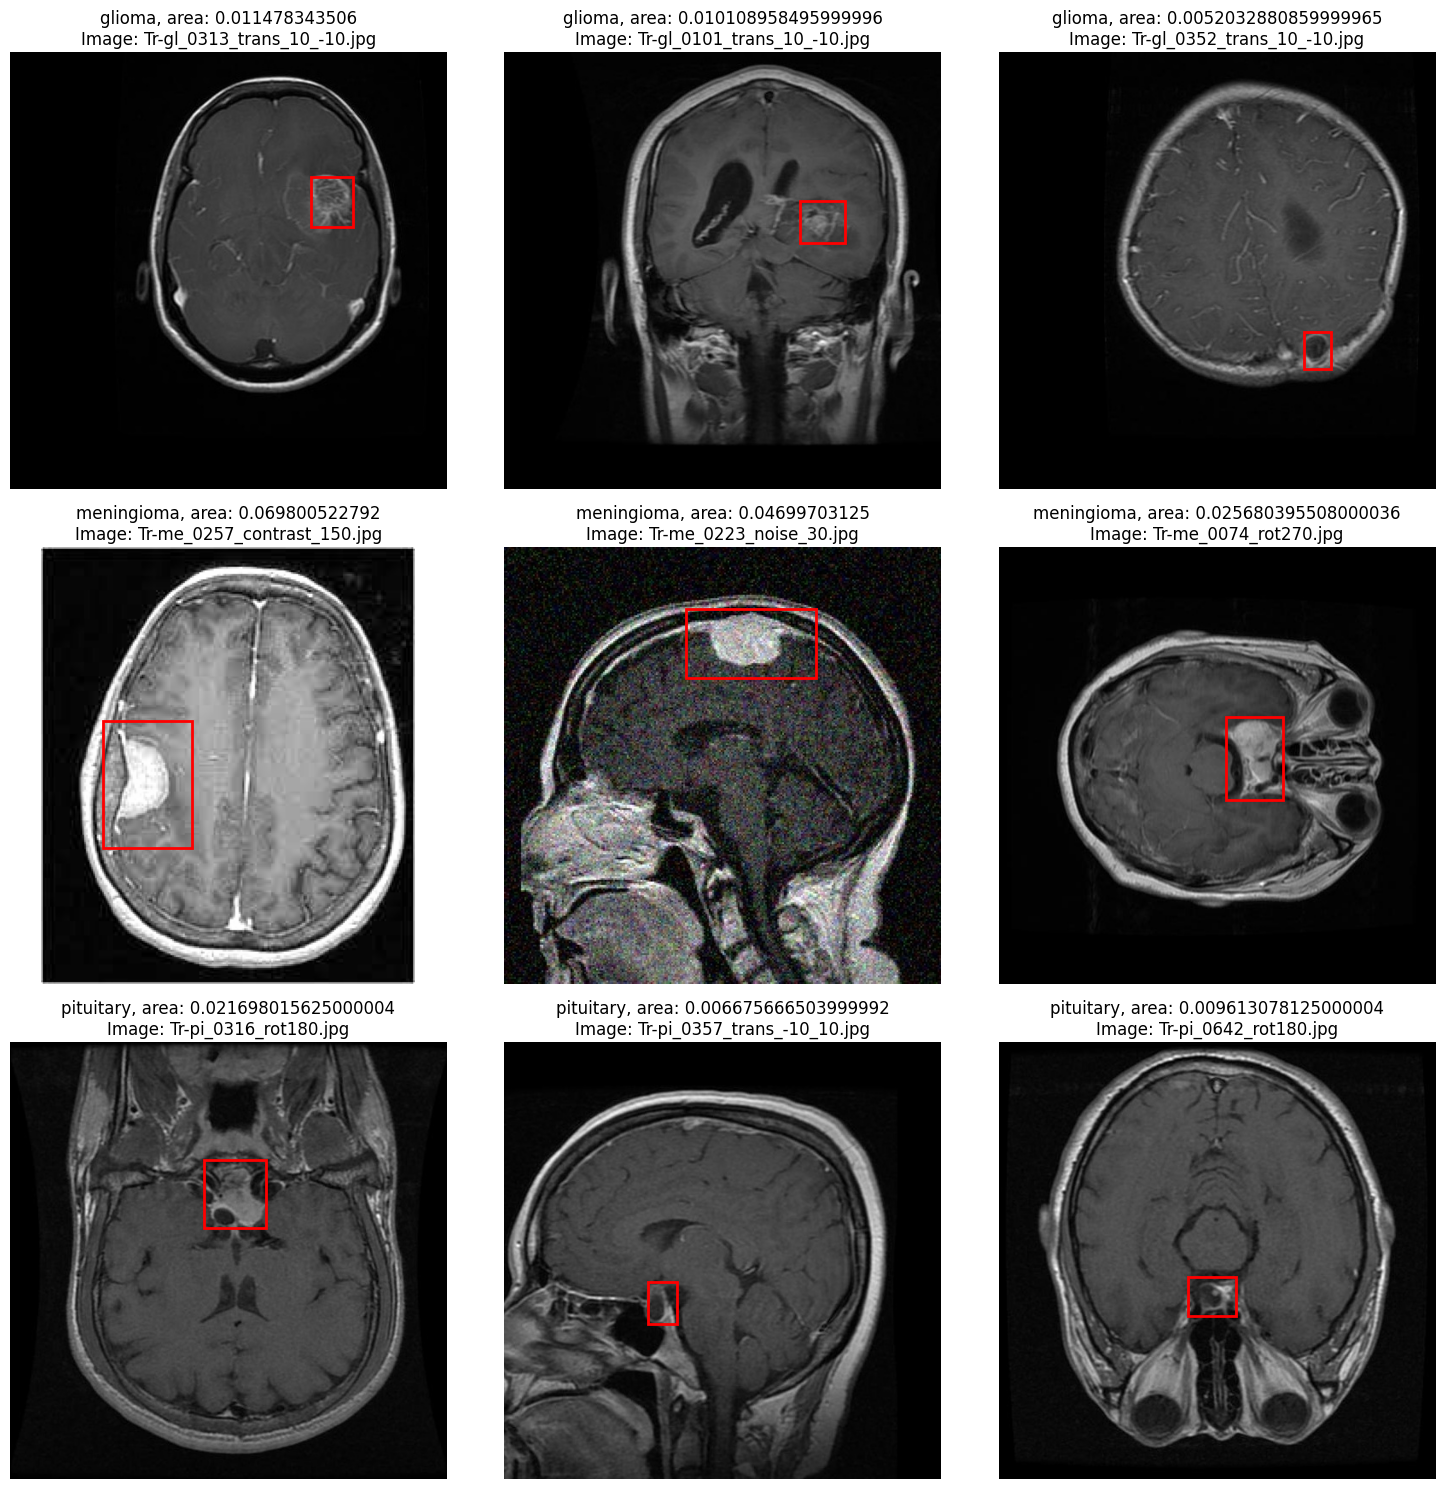

In [25]:
visualize_random_samples(augmented_dataset_path, samples_per_class=3)

### Tumor Class, Size Distribution

Now let's look at the augmented data distribution of classes and sizes, and make sure it still aligns with the original data.

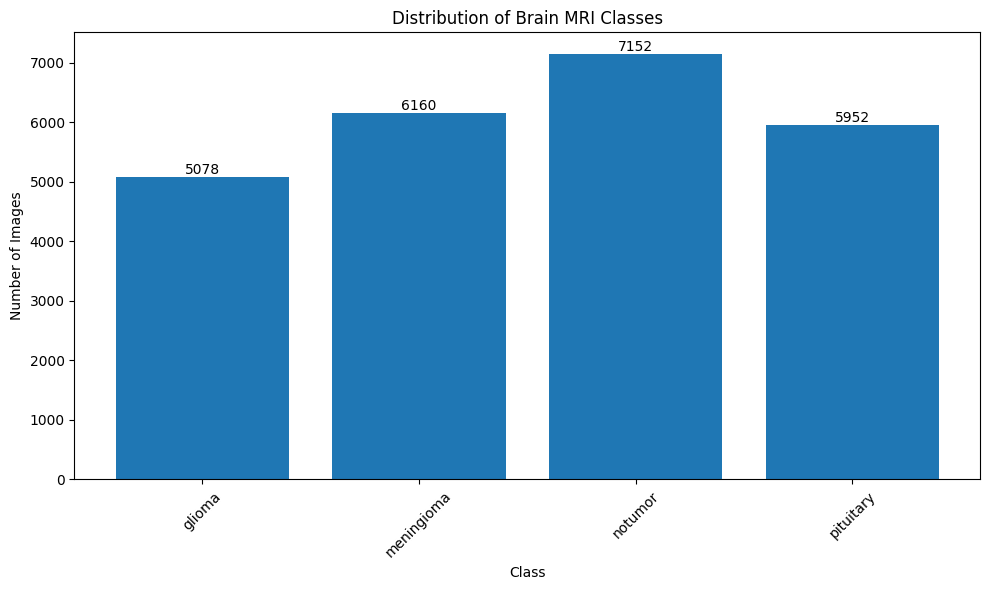

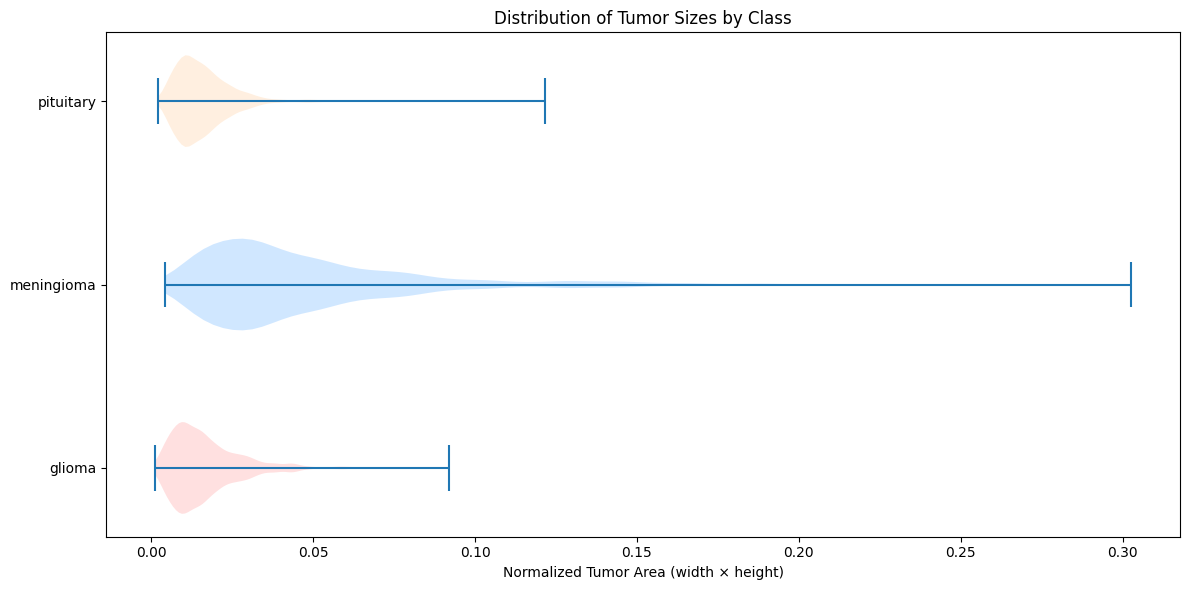

<Figure size 1200x600 with 0 Axes>

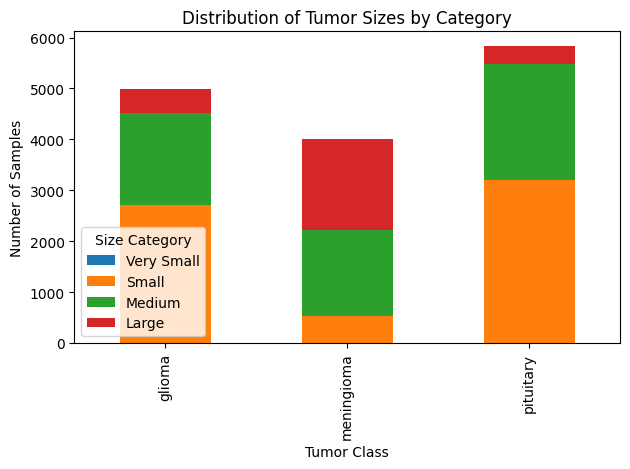


Summary Statistics:

GLIOMA:
Mean area: 0.0169
Median area: 0.0142
Std dev: 0.0113
Min area: 0.0012
Max area: 0.0918

MENINGIOMA:
Mean area: 0.0486
Median area: 0.0377
Std dev: 0.0362
Min area: 0.0041
Max area: 0.3026

PITUITARY:
Mean area: 0.0168
Median area: 0.0144
Std dev: 0.0108
Min area: 0.0021
Max area: 0.1216


In [10]:
analyze_tumor_dataset(augmented_dataset_path)

### Augmented Data Notes

As we can see, the augmented data has kept the same distributions but has greatly increased the number of samples in the dataset. This is great, as we can now train a model on a larger dataset, which should help with generalization.

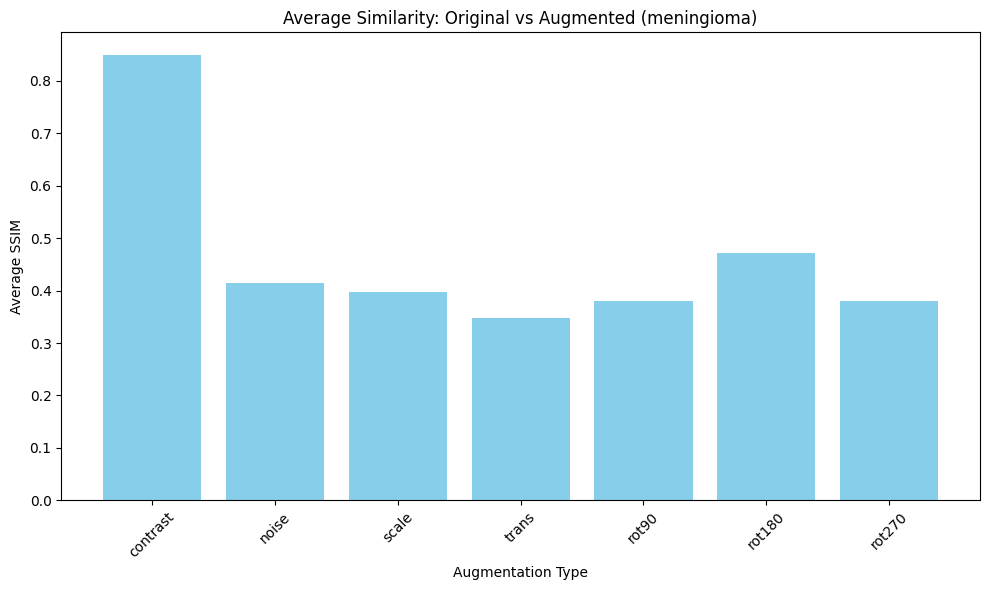

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
from collections import defaultdict

class AugmentationSimilarityAnalyzer:
    def __init__(self, original_dir, augmented_dir):
        """
        Initialize the analyzer with original and augmented directories.

        Args:
            original_dir (str): Path to the directory containing original images
            augmented_dir (str): Path to the directory containing augmented images
        """
        self.original_dir = Path(original_dir)
        self.augmented_dir = Path(augmented_dir)

    def calculate_similarity(self, img1, img2):
        """
        Calculate the Structural Similarity Index (SSIM) between two images.

        Args:
            img1 (np.array): First image
            img2 (np.array): Second image

        Returns:
            float: SSIM value
        """
        img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        return ssim(img1_gray, img2_gray)

    def analyze_similarity(self, tumor_class):
        """
        Analyze and plot similarity between original images and augmented images for a specific class.

        Args:
            tumor_class (str): Name of the tumor class to analyze
        """
        # Find all original images
        original_images = list(self.original_dir.glob(f"{tumor_class}/*.jpg"))
        similarity_scores = defaultdict(list)

        for original_image_path in original_images:
            original_id = original_image_path.stem
            original_image = cv2.imread(str(original_image_path))

            # Find all augmented images with the same ID
            augmented_images = list(self.augmented_dir.glob(f"{tumor_class}/{original_id}_*.jpg"))
            for aug_image_path in augmented_images:
                aug_image = cv2.imread(str(aug_image_path))
                similarity = self.calculate_similarity(original_image, aug_image)

                # Extract augmentation type from the filename
                aug_type = aug_image_path.stem[len(original_id) + 1:].split('_')[0]
                similarity_scores[aug_type].append(similarity)

        # Calculate average similarity for each augmentation type
        avg_similarity = {
            aug_type: np.mean(scores) for aug_type, scores in similarity_scores.items()
        }

        # Plot similarity scores
        self.plot_similarity(avg_similarity, tumor_class)

    def plot_similarity(self, avg_similarity, tumor_class):
        """
        Plot average similarity scores for a specific class.

        Args:
            avg_similarity (dict): Dictionary of augmentation types and their average similarity
            tumor_class (str): Name of the tumor class
        """
        plt.figure(figsize=(10, 6))
        plt.bar(avg_similarity.keys(), avg_similarity.values(), color='skyblue')
        plt.title(f'Average Similarity: Original vs Augmented ({tumor_class})')
        plt.xlabel('Augmentation Type')
        plt.ylabel('Average SSIM')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

analyzer = AugmentationSimilarityAnalyzer("./dataset/raw/raw/", "./dataset/augmented/")
analyzer.analyze_similarity("meningioma")
